In [489]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 


In [1]:
df = pd.read_csv("../Figure7_PLS-DA/pheno_terpenoids.tsv",sep="\t",index_col=0)
df.head()

,wf,thrips,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,non-toxic,non-toxic,0.00000,0.0,0.000,0.0000,88210.77165,0.00000,0.00000,32617.13711,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S per LA1278,non-toxic,toxic,234383.78650,0.0,0.000,0.0000,131824.19000,0.00000,800290.02030,0.00000,...,0.0,0.0,0.0,9153.957334,0.0,0.0,0.0,0.0,0.0,0.0
S hua LA1364,non-toxic,non-toxic,0.00000,0.0,104528.752,45335.4665,27304.44693,90430.09761,0.00000,0.00000,...,0.0,0.0,0.0,5561.180230,0.0,0.0,0.0,0.0,0.0,0.0
S che LA1401,non-toxic,toxic,0.00000,0.0,0.000,0.0000,457891.15640,0.00000,32459.72293,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
S pim LA1578,non-toxic,toxic,12809.66965,0.0,0.000,0.0000,221391.28520,0.00000,0.00000,24737.81096,...,0.0,0.0,0.0,9495.496480,0.0,0.0,0.0,0.0,0.0,0.0


Whitefly analysis
Train and test splits

In [387]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]
#X.head()

In [257]:
# define main random forest routine.. uses 6 splits to partition data
from sklearn.metrics import classification_report

def single_run(X,y,rs,disp=False):

    nrsplits = 6
    
    vi = pd.DataFrame(np.zeros([X.shape[1],nrsplits]))    
    dfy = pd.DataFrame(y,columns=['tox'])
    yhat = pd.DataFrame(['']*len(y),columns=['predict_tox'],dtype=np.str)
    
    kfold = StratifiedKFold(n_splits=nrsplits,random_state=rs)
    
    splitnr = 0

    for train_index, test_index in kfold.split(X,y):
        nt = 1/sum(stratify_info[train_index]==0)
        tx = 1/sum(stratify_info[train_index]==1)    
        rf = RandomForestClassifier(n_estimators=1000,class_weight={"toxic":tx,"non-toxic":nt},random_state=rs)

        rf = rf.fit(X.iloc[train_index,:],dfy.iloc[train_index].values.ravel())

        # predict class values
        y_pred = rf.predict(X.iloc[test_index,:])
        for j in range(len(y_pred)):    
            yhat.iloc[test_index[j]] = y_pred[j]    
                  
        vi.iloc[:,splitnr] = rf.feature_importances_
        splitnr+=1
        
    if disp:
        print(classification_report(y, yhat))
        pdata = vi.copy()
        pdata.rename(columns={i:'split{0}'.format(i) for i in range(6)},inplace=True)
        pdata['x'] = range(vi.shape[0])
        pdata.head()
        sns.lineplot(data=pdata)
    
    return [vi.mean(axis=1),yhat]

In [332]:
feature_importance=pd.DataFrame(columns=['run{0}'.format(i+1) for i in range(5)])
yhat = pd.DataFrame(columns=['run{0}'.format(i+1) for i in range(5)])

#run the normal procedure 5 times with different seeds
#concatenate the predicted y's and the feature importance for analysis later
for i in range(5):
    a,yh = single_run(X,y,i,False)
    feature_importance.iloc[:,i] = a
    yhat.iloc[:,i]=yh.iloc[:,0]


mi = feature_importance.mean(axis=1)
    

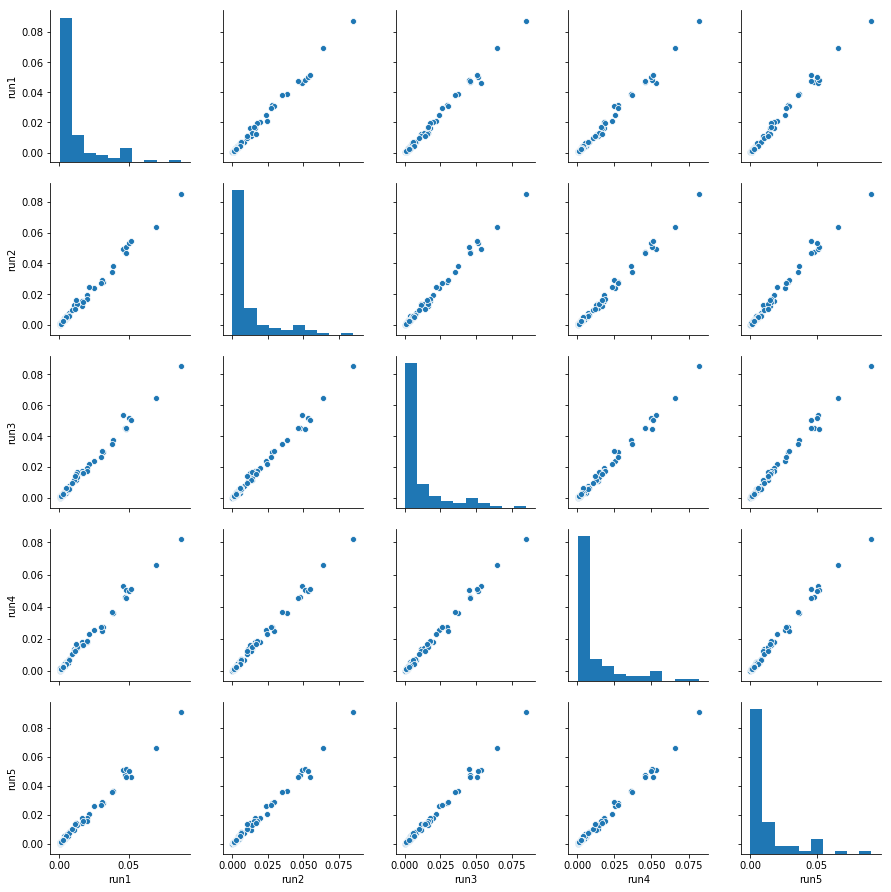

In [286]:
sns.pairplot(data=feature_importance)

In [490]:
nrperm = 100
yperms = pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
secure_random = random.SystemRandom()

In [491]:
feature_importance_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
yhat_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])

for perm in range(nrperm):    
    # generate random numbers
    randomfloat = [secure_random.random() for r in range(len(y))]
    # create new ynew matrix
    ynew = dfy.iloc[np.argsort(randomfloat)]
    # reindex the vector
    ynew.index = range(len(y))
    # store this matrix for later
    yperms.iloc[:,perm]=ynew.iloc[:,0].copy()
    
    # set to fixed seed 1234 (arbitraryly)
    a,yh = single_run(X,ynew,1234,False)
    feature_importance_perm.iloc[:,perm] = a
    yhat_perm.iloc[:,perm]=yh.iloc[:,0]
    

In [492]:
# routine to determine pvalue
def iperc(x,X):
    
    df = pd.DataFrame(index=X.index,columns=['p-value'])
    
    for i in range(len(x)):            
        pn = sum(X.iloc[i,:]<x.iloc[i])/X.shape[0]
        pp = sum(X.iloc[i,:]>=x.iloc[i])/X.shape[0]
    
        df.iloc[i] = min(pn,pp)
            
    return df
    

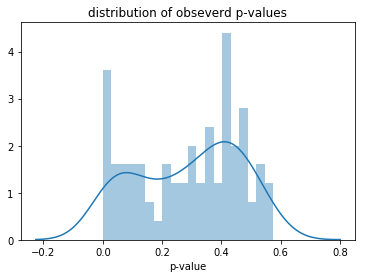

In [493]:
pvalues = iperc(mi,feature_importance_perm)
sns.distplot(pvalues.iloc[:,0].astype('float'),20)
plt.title('distribution of obseverd p-values');

In [494]:
# only select those variables that have p-value smaller than 0.05 (after bonferroni correction)
mysel = pvalues.loc[pvalues.iloc[:,0]<(0.05/X.shape[0]),:].sort_values('p-value')

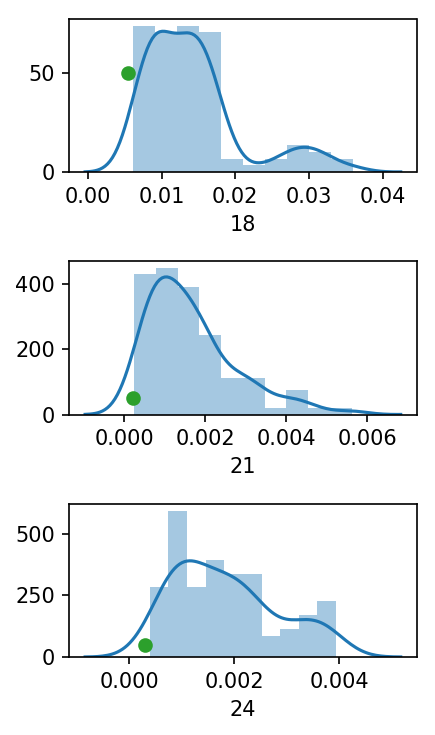

In [498]:
# plot those variables
nrplots = len(mysel.index.values)
fig = plt.figure(figsize=([3,5]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.iloc[mysel.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(mi[mysel.index.values[i]],0,mi[mysel.index.values[i]],50,'o')
    
plt.tight_layout()

(3, 1)